## Midterm Project


## Task 1: Defining your Problem and Audience

✅ Deliverables

#### Problem Statement 

Develop an AI-powered Bible study tool that empowers users to quickly find answers to their questions directly within the Bible text. By leveraging Large Language Models (LLMs), the tool will analyze user queries, identify relevant passages, and provide contextual insights from surrounding verses and cross-references, eliminating the need for extensive manual searching and memorization.

## Task 2: Propose a Solution

✅ Deliverables

#### Application Framework

<img src="img/arch.png" />

- LLM 
    - "gpt-4o" is used for agent reasoning. 
- Embedding Model
    - my fine tuned embedding model based on Snowflake/snowflake-arctic-embed-l
- Orchestration
    - There are two nodes in the graph: 1 agent node, 1 action node. The agent node does some reasoning based on the user queries and determines which tool in the action node to use. The action node provides a tool set for the agent node to use. In the first phase of this project, a RAG chain is the only available tool. The book of Genesis is saved in the vector database in RAG.
- Vector Database
    - Qdrant as it is a popular choirc for RAG. It is open sourced, excels at performing fast, accurate, and scalable vector similarity searches.
- Monitoring
- Evaluation
    - RAGAS is used to generate synthetic data and evaluate the agent langgraph by using the following metrics
        - Context Recall
        - Faithfulness
        - Factual correctness
        - answer relevancy
        - context entity recall
        - noise sensitivity relevant
- User Interface
    - Chainlit as it is open sourced and ease to use


## Task 3: Dealing with the Data

✅ Deliverables
1. Describe all of your data sources and external APIs, and describe what you’ll use them for.

    - The book of Genesis is downloaded to local from https://www.vatican.va/archive/bible/genesis/documents/bible_genesis_en.html by using curl command. And then it is loaded by using langchain director loader.

2. Describe the default chunking strategy that you will use.  Why did you make this decision?

    - RecursiveCharacterTextSplitter is used to chunk the document. This text splitter is designed to split text recursively based on specified characters. It prioritizes splitting by certain characters (like paragraphs or sentences) before resorting to splitting by character length. The parameter chunk_overlap = 100 is useful for maintaining context and avoiding loss of information when processing the chunks independently.



## Task 4: Building a Quick End-to-End Prototype

✅ Deliverables

https://huggingface.co/spaces/kcheng0816/BibleStudy

### Installing Dependencies

In [1]:
!uv pip install -qU ragas==0.2.10

In [2]:
!uv pip install -qU cohere langchain_cohere langchain_huggingface

In [3]:
!uv pip install -qU sentence_transformers datasets pyarrow

In [4]:
!uv pip install -qU faiss-cpu python-pptx==1.0.2 nltk==3.9.1 beautifulsoup4 lxml

In [5]:
!uv pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

### Environment Variables

In [6]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [7]:
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE5 - Midterm Sample - {uuid4().hex[0:8]}"


### Data Preparation

In [8]:
!curl https://www.vatican.va/archive/bible/genesis/documents/bible_genesis_en.html -o data/bible_genesis_en.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  216k  100  216k    0     0   117k      0  0:00:01  0:00:01 --:--:--  118k


In [9]:
from langchain_community.document_loaders import DirectoryLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()

libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.


In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap = 100
)

split_documents = text_splitter.split_documents(docs)
len(split_documents)

307

### Embedding Model and Vector Store

In [11]:
from langchain_huggingface import HuggingFaceEmbeddings

base_embedding_model = HuggingFaceEmbeddings(model_name="Snowflake/snowflake-arctic-embed-l")

#from langchain_openai.embeddings import OpenAIEmbeddings

#embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

In [13]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

client.create_collection(
    collection_name="genesis_bible",
    vectors_config=VectorParams(size=1024, distance=Distance.COSINE),
)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="genesis_bible",
    embedding=base_embedding_model,
)

In [14]:
_ = vector_store.add_documents(documents=split_documents)

### Retriever

In [15]:
retriever = vector_store.as_retriever(search_kwargs={"k": 5})

In [16]:
def retrieve(state):
  retrieved_docs = retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

### Augmented

In [17]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
You are a helpful assistant who answers questions based on provided context. You must only use the provided context, and cannot use your own knowledge.

### Question
{question}

### Context
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

### Generation

In [18]:
from langchain_openai import ChatOpenAI
from langchain.chat_models import init_chat_model
from langchain_core.rate_limiters import InMemoryRateLimiter

rate_limiter = InMemoryRateLimiter(
    requests_per_second=1,  # <-- make a request once every 1 seconds!!
    check_every_n_seconds=0.1,  # Wake up every 100 ms to check whether allowed to make a request,
    max_bucket_size=10,  # Controls the maximum burst size.
)

llm = init_chat_model("gpt-4o-mini", rate_limiter=rate_limiter)

#hit langsmith rate limit
#llm = ChatOpenAI(model="gpt-4o-mini")

In [19]:
def generate(state):
  docs_content = "\n\n".join(doc.page_content for doc in state["context"])
  messages = rag_prompt.format_messages(question=state["question"], context=docs_content)
  response = llm.invoke(messages)
  return {"response" : response.content}

In [20]:
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class State(TypedDict):
  question: str
  context: List[Document]
  response: str

In [21]:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [22]:
response = graph.invoke({"question" : "How the universe was created?"})

In [23]:
response["response"]

'The universe was created by God in the beginning, as described in the Book of Genesis. Initially, the earth was formless and covered in darkness. God then spoke, saying, "Let there be light," and light came into existence. This marked the separation of light from darkness, establishing the cycle of day and night.\n\nOver the subsequent days, God continued to create: \n\n- On the second day, God created a dome to separate the waters above from the waters below, calling the dome Sky.\n- On the third day, God gathered the waters to reveal dry land, which He called Earth, and commanded the earth to produce vegetation.\n- On the fourth day, God created the sun, moon, and stars to provide light and to serve as markers for time.\n- On the fifth day, God filled the waters with living creatures and created birds to fly in the sky.\n- On the sixth day, God made land animals and formed man from the dust of the ground.\n\nFinally, on the seventh day, God completed His work and rested, blessing an

In [24]:
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool

@tool
def ai_rag_tool(question: str) -> str:
    """Useful for when you need to answer questions about Bible """
    response = graph.invoke({"question": question})
    return {
        "message": [HumanMessage(content=response["response"])],
        "context": response["context"]
    }

### Tool Belt

In [25]:
tool_belt = [
    ai_rag_tool
]

### LangGraph Agent

### Binding the tools to the LLM

In [26]:
llm = init_chat_model("gpt-4o", temperature=0, rate_limiter=rate_limiter)
llm_with_tools = llm.bind_tools(tool_belt)

### Define the State

In [27]:
from langgraph.graph import END
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated
from langchain_core.documents import Document


class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    context:List[Document]

In [28]:
from langgraph.prebuilt import ToolNode

def call_mode(state):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {
        "messages": [response],
        "context": state.get("context",[])
    }

tool_node = ToolNode(tool_belt)

In [29]:
def should_continue(state):
    last_message = state["messages"][-1]

    if last_message.tool_calls:
        return "action"
    
    return END

### Building the graph

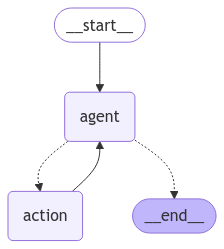

In [30]:
from langgraph.graph import StateGraph, END
from IPython.display import Image, display

uncompiled_graph = StateGraph(AgentState)

uncompiled_graph.add_node("agent", call_mode)
uncompiled_graph.add_node("action", tool_node)

uncompiled_graph.set_entry_point("agent")

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue
)

uncompiled_graph.add_edge("action", "agent")

# Compile and display the graph for a visual overview
compiled_graph = uncompiled_graph.compile()
display(Image(compiled_graph.get_graph(xray=True).draw_mermaid_png()))

In [31]:
from langchain_core.messages import HumanMessage

inputs = {"messages" : [HumanMessage(content="How many days did GOD take on creation the whole universe?")]}

async for chunk in compiled_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        if node == "action":
            print(f"Tool Used: {values['messages'][0].name}")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZeF76fzqEqXtzALp8HzRv2r4', 'function': {'arguments': '{"question":"How many days did God take to create the universe according to the Bible?"}', 'name': 'ai_rag_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 62, 'total_tokens': 93, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2eaf2427-6fa4-4d0b-82af-dc173620d262-0', tool_calls=[{'name': 'ai_rag_tool', 'args': {'question': 'How many days did God take to create the universe according to the Bible?'}, 'id': 'call_ZeF76fzqEqXtzALp8HzRv2r4', 'type': 'tool_call'}], usage_me

In [32]:
from langchain_core.messages import HumanMessage

inputs = {"messages" : [HumanMessage(content="Could you please tell me when was the book of Genesis was finished?")]}

async for chunk in compiled_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        if node == "action":
            print(f"Tool Used: {values['messages'][0].name}")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ToFmtcFoqrGLPrlmYjAR5f1E', 'function': {'arguments': '{"question":"When was the book of Genesis finished?"}', 'name': 'ai_rag_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 64, 'total_tokens': 88, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-36dd8e08-4c49-408b-bff5-3a5e83c0953b-0', tool_calls=[{'name': 'ai_rag_tool', 'args': {'question': 'When was the book of Genesis finished?'}, 'id': 'call_ToFmtcFoqrGLPrlmYjAR5f1E', 'type': 'tool_call'}], usage_metadata={'input_tokens': 64, 'output_tokens': 24, 'total_tokens': 88, '

## Task 5: Creating a Golden Test Data Set

### Ragas Baseline

#### Abstracted SDG

In [33]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

model = init_chat_model("gpt-4o", temperature=0, rate_limiter=rate_limiter)

generator_llm = LangchainLLMWrapper(model)
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [34]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/1 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/1 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/1 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/42 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/61 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/10 [00:00<?, ?it/s]

In [35]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What role does the dome play in the creation n...,[Chapter 1 [1:1] In the beginning when God cre...,"In the creation narrative, the dome is created...",single_hop_specifc_query_synthesizer
1,In the context of the creation narrative found...,[Chapter 2 [2:1] Thus the heavens and the eart...,"In the creation narrative of Genesis, the Euph...",single_hop_specifc_query_synthesizer
2,Why LORD God make man leave garden?,[Chapter 3 [3:1] Now the serpent was more craf...,The LORD God sent the man forth from the garde...,single_hop_specifc_query_synthesizer
3,Who was Eve in the context of Genesis Chapter 4?,[Chapter 4 [4:1] Now the man knew his wife Eve...,Eve was the wife of Adam and the mother of Cai...,single_hop_specifc_query_synthesizer
4,What is the significance of Jared in the genea...,[Chapter 5 [5:1] This is the list of the desce...,Jared is significant in the genealogy of Adam ...,single_hop_specifc_query_synthesizer
5,Why Jacob go to Bethel and what happen with hi...,[<1-hop>\n\nChapter 35 [35:1] God said to Jaco...,Jacob went to Bethel because God told him to a...,multi_hop_specific_query_synthesizer
6,How did Sarai's journey with Abram from Ur of ...,"[<1-hop>\n\nher mother said, ""Let the girl rem...","Sarai, Abram's wife, initially journeyed with ...",multi_hop_specific_query_synthesizer
7,"How did the Israelites, led by Jacob, end up i...",[<1-hop>\n\nChapter 37 [37:1] Jacob settled in...,"The Israelites, led by Jacob, ended up in Egyp...",multi_hop_specific_query_synthesizer
8,How does the significance of Shechem in Abram'...,"[<1-hop>\n\nand his daughter-in-law Sarai, his...","In Abram's journey, Shechem is significant as ...",multi_hop_specific_query_synthesizer
9,What is the significance of Zebulun's settleme...,[<1-hop>\n\nfather laid his right hand on the ...,"In Jacob's blessings to his sons, Zebulun is p...",multi_hop_specific_query_synthesizer


In [36]:
dataset.upload()

Testset uploaded! View at https://app.ragas.io/dashboard/alignment/testset/466d70a0-ca95-48f8-8f3b-50f05d09583d


'https://app.ragas.io/dashboard/alignment/testset/466d70a0-ca95-48f8-8f3b-50f05d09583d'

### Evaluating the RAG with Ragas

In [37]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="How many days did GOD take on creation the whole universe?")]
result = compiled_graph.invoke({"messages": messages})

In [38]:
import re

def extract_page_content(tool_message_str):
    # Pattern to match page_content='...' sections
    pattern = r"page_content='([^']*)'[^']*"
    
    # Find all matches
    matches = re.findall(pattern, tool_message_str)
    
    return matches



extract_page_content(result["messages"][-2].content)

['[2:2] And on the seventh day God finished the work that he had done, and he rested on the seventh day from all the work that he had done. [2:3] So God blessed the seventh day and hallowed it, because on it God rested from all the work that he had done in creation. [2:4] These are the generations of the heavens and the earth when they were created. In the day that the LORD God made the earth and the heavens, [2:5] when no plant of the field was yet in the earth and no herb of the field had yet sprung up - for the LORD God had not caused it to rain upon the earth, and there was no one to till the ground; [2:6] but a stream would rise from the earth, and water the whole face of the ground - [2:7] then the LORD God formed man from the dust of',
 'light Day, and the darkness he called Night. And there was evening and there was morning, the first day. [1:6] And God said, "Let there be a dome in the midst of the waters, and let it separate the waters from the waters." [1:7] So God made the 

In [39]:
import time

for test_row in dataset:
    inputs = {"messages": [HumanMessage(content=test_row.eval_sample.user_input)]}
    response = compiled_graph.invoke(inputs)
    test_row.eval_sample.response = response["messages"][-1].content
    test_row.eval_sample.retrieved_contexts = extract_page_content(response["messages"][-2].content)
    time.sleep(60)


✅ Deliverables

#### A Golden Test Dataset

In [40]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,What role does the dome play in the creation n...,"[light Day, and the darkness he called Night. ...",[Chapter 1 [1:1] In the beginning when God cre...,"In the creation narrative, the dome plays a si...","In the creation narrative, the dome is created...",single_hop_specifc_query_synthesizer
1,In the context of the creation narrative found...,[is Pishon; it is the one that flows around th...,[Chapter 2 [2:1] Thus the heavens and the eart...,"In the creation narrative found in Genesis, th...","In the creation narrative of Genesis, the Euph...",single_hop_specifc_query_synthesizer
2,Why LORD God make man leave garden?,"[for out of it you were taken; you are dust, a...",[Chapter 3 [3:1] Now the serpent was more craf...,The LORD God made man leave the Garden of Eden...,The LORD God sent the man forth from the garde...,single_hop_specifc_query_synthesizer
3,Who was Eve in the context of Genesis Chapter 4?,"[for out of it you were taken; you are dust, a...",[Chapter 4 [4:1] Now the man knew his wife Eve...,"In Genesis Chapter 4, Eve is described as the ...",Eve was the wife of Adam and the mother of Cai...,single_hop_specifc_query_synthesizer
4,What is the significance of Jared in the genea...,[and it grieved him to his heart. [6:7] So the...,[Chapter 5 [5:1] This is the list of the desce...,Jared is a figure mentioned in the genealogy o...,Jared is significant in the genealogy of Adam ...,single_hop_specifc_query_synthesizer
5,Why Jacob go to Bethel and what happen with hi...,"[that the sons of Laban were saying, ""Jacob ha...",[<1-hop>\n\nChapter 35 [35:1] God said to Jaco...,Jacob went to Bethel because the LORD instruct...,Jacob went to Bethel because God told him to a...,multi_hop_specific_query_synthesizer
6,How did Sarai's journey with Abram from Ur of ...,[the famine was severe in the land. [12:11] Wh...,"[<1-hop>\n\nher mother said, ""Let the girl rem...",Sarai's journey with Abram from Ur of the Chal...,"Sarai, Abram's wife, initially journeyed with ...",multi_hop_specific_query_synthesizer
7,"How did the Israelites, led by Jacob, end up i...","[[47:1] So Joseph went and told Pharaoh, ""My f...",[<1-hop>\n\nChapter 37 [37:1] Jacob settled in...,"The Israelites, led by Jacob, ended up in Egyp...","The Israelites, led by Jacob, ended up in Egyp...",multi_hop_specific_query_synthesizer
8,How does the significance of Shechem in Abram'...,[Jacob came in from the field. When they heard...,"[<1-hop>\n\nand his daughter-in-law Sarai, his...",The significance of Shechem in Abram's journey...,"In Abram's journey, Shechem is significant as ...",multi_hop_specific_query_synthesizer
9,What is the significance of Zebulun's settleme...,"[that the sons of Laban were saying, ""Jacob ha...",[<1-hop>\n\nfather laid his right hand on the ...,The significance of Zebulun's settlement by th...,"In Jacob's blessings to his sons, Zebulun is p...",multi_hop_specific_query_synthesizer


In [41]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [42]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(init_chat_model("gpt-4o", temperature=0, rate_limiter=rate_limiter))

In [43]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=1440)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Exception raised in Job[53]: RateLimitError(Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}})
Exception raised in Job[59]: RateLimitError(Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}})


{'context_recall': 0.5500, 'faithfulness': 0.5588, 'factual_correctness': 0.6360, 'answer_relevancy': 0.8632, 'context_entity_recall': 0.5267, 'noise_sensitivity_relevant': 0.1293}

### Task 6: Fine-Tuning Open-Source Embeddings

✅ Deliverables

The fine tuned model: https://huggingface.co/kcheng0816/finetuned_arctic_genesis

In [44]:
import nest_asyncio

nest_asyncio.apply()

In [45]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import BSHTMLLoader

path = "data/"
text_loader = DirectoryLoader(path, glob="*.html", loader_cls=BSHTMLLoader)

In [46]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap  = 20,
    length_function = len
)

In [47]:
training_documents = text_splitter.split_documents(text_loader.load())

In [48]:
len(training_documents)

275

In [49]:
import uuid

id_set = set()

for document in training_documents:
  id = str(uuid.uuid4())
  while id in id_set:
    id = uuid.uuid4()
  id_set.add(id)
  document.metadata["id"] = id

In [50]:
training_split_documents = training_documents[:len(training_documents) - 70]
val_split_documents = training_documents[len(training_documents) - 75:275-35]
test_split_documents = training_documents[275-35:]
print(len(training_split_documents))
print(len(val_split_documents))
print(len(test_split_documents))

205
40
35


### Constructing a fine tuning dataset

In [51]:
from langchain_openai import ChatOpenAI

qa_chat_model = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

In [52]:
from langchain_core.prompts import ChatPromptTemplate

qa_prompt = """\
Given the following context, you must generate questions based on only the provided context.

You are to generate {n_questions} questions which should be provided in the following format:

1. QUESTION #1
2. QUESTION #2
...

Context:
{context}
"""

qa_prompt_template = ChatPromptTemplate.from_template(qa_prompt)

In [53]:
question_generation_chain = qa_prompt_template | qa_chat_model

In [54]:
import tqdm
import re

async def create_questions(documents, n_questions):
  questions = {}
  relevant_docs = {}

  # Process each document to generate questions
  for doc in tqdm.tqdm(documents, desc="Processing documents"):
        # Generate n_questions for each document using the question generation chain
        generated_questions = question_generation_chain.invoke({
            "context": doc.page_content,
            "n_questions": n_questions
        })

        # For each generated question
        for question in generated_questions.content.split('\n'):
            #remove the question number at the begining
            question = re.sub(r"(^\d+. )", "", question)
            
            # Generate a unique ID for the question
            question_id = str(uuid.uuid4())

            # Add to questions dictionary
            questions[question_id] = question.strip()
                
            # Add to relevant docs dictionary - link question to source document
            relevant_docs[question_id] = [doc.metadata["id"]]
              
  return questions, relevant_docs

In [57]:
training_questions, training_relevant_contexts = await create_questions(training_split_documents, 2)

Processing documents: 100%|██████████| 205/205 [03:57<00:00,  1.16s/it]


In [58]:
val_questions, val_relevant_contexts = await create_questions(val_split_documents, 2)

Processing documents: 100%|██████████| 40/40 [00:45<00:00,  1.14s/it]


In [59]:
test_questions, test_relevant_contexts = await create_questions(test_split_documents, 2)
print(test_questions)
print(test_relevant_contexts)

Processing documents: 100%|██████████| 35/35 [00:37<00:00,  1.07s/it]

{'0fee006f-883d-4b8b-9f09-7c953ec47164': 'What will happen to the father if he sees that the boy is not with them?', 'bd84897f-fedf-4849-9ba1-ab5541203182': 'Why does the servant offer to remain as a slave in place of the boy?', '7f2a9486-0cd6-4f81-b65b-bdb2039796c2': 'What did Joseph cry out to those around him before revealing his identity to his brothers?', 'b7d866ee-11ee-48dd-adb0-14c8ba11dc93': "How did Joseph's brothers react when he made himself known to them?", 'ef57f4f9-e4d8-4c3b-9600-e3588b73ce18': 'What has been the duration of the famine in the land mentioned in the context?', 'e3eb43c8-e737-4e7d-97e6-5b89305a2f68': 'Who is Joseph instructed to tell about his position in Egypt and the invitation to come down?', '0a592f96-14af-436d-937d-588e36db149b': 'What did Joseph ask his brothers to tell their father about his status in Egypt?', 'ad279a30-0093-4c9e-ae56-ea8fb32abe36': 'How did Joseph and his brothers react when they were reunited?', 'e393a2e9-235b-4df9-9f6a-6c3c25f1bfe6

In [60]:
for query_id, query in test_questions.items():
    print(f"{query_id} : {query}")

0fee006f-883d-4b8b-9f09-7c953ec47164 : What will happen to the father if he sees that the boy is not with them?
bd84897f-fedf-4849-9ba1-ab5541203182 : Why does the servant offer to remain as a slave in place of the boy?
7f2a9486-0cd6-4f81-b65b-bdb2039796c2 : What did Joseph cry out to those around him before revealing his identity to his brothers?
b7d866ee-11ee-48dd-adb0-14c8ba11dc93 : How did Joseph's brothers react when he made himself known to them?
ef57f4f9-e4d8-4c3b-9600-e3588b73ce18 : What has been the duration of the famine in the land mentioned in the context?
e3eb43c8-e737-4e7d-97e6-5b89305a2f68 : Who is Joseph instructed to tell about his position in Egypt and the invitation to come down?
0a592f96-14af-436d-937d-588e36db149b : What did Joseph ask his brothers to tell their father about his status in Egypt?
ad279a30-0093-4c9e-ae56-ea8fb32abe36 : How did Joseph and his brothers react when they were reunited?
e393a2e9-235b-4df9-9f6a-6c3c25f1bfe6 : What instructions did Pharaoh g

In [61]:
import json

training_corpus = {train_item.metadata["id"] : train_item.page_content for train_item in training_split_documents}

train_dataset = {
    "questions" : training_questions,
    "relevant_contexts" : training_relevant_contexts,
    "corpus" : training_corpus
}

with open("training_dataset.jsonl", "w") as f:
  json.dump(train_dataset, f)

In [62]:
val_corpus = {val_item.metadata["id"] : val_item.page_content for val_item in val_split_documents}

val_dataset = {
    "questions" : val_questions,
    "relevant_contexts" : val_relevant_contexts,
    "corpus" : val_corpus
}

with open("val_dataset.jsonl", "w") as f:
  json.dump(val_dataset, f)

In [63]:
train_corpus = {test_item.metadata["id"] : test_item.page_content for test_item in test_split_documents}

test_dataset = {
    "questions" : test_questions,
    "relevant_contexts" : test_relevant_contexts,
    "corpus" : train_corpus
}

with open("test_dataset.jsonl", "w") as f:
  json.dump(test_dataset, f)

In [64]:
from sentence_transformers import SentenceTransformer

model_id = "Snowflake/snowflake-arctic-embed-l"
model = SentenceTransformer(model_id)

In [65]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sentence_transformers import InputExample

In [66]:
BATCH_SIZE = 10

In [67]:
#Prepare the Training Data
corpus = train_dataset['corpus']
queries = train_dataset['questions']
relevant_docs = train_dataset['relevant_contexts']

examples = []
for query_id, query in queries.items():
    doc_id = relevant_docs[query_id][0]
    text = corpus[doc_id]
    example = InputExample(texts=[query, text])
    examples.append(example)

In [68]:
loader = DataLoader(
    examples, batch_size=BATCH_SIZE
)

In [69]:
from sentence_transformers.losses import MatryoshkaLoss, MultipleNegativesRankingLoss

matryoshka_dimensions = [768, 512, 256, 128, 64]
inner_train_loss = MultipleNegativesRankingLoss(model)
train_loss = MatryoshkaLoss(
    model, inner_train_loss, matryoshka_dims=matryoshka_dimensions
)

In [70]:
from sentence_transformers.evaluation import InformationRetrievalEvaluator

corpus = val_dataset['corpus']
queries = val_dataset['questions']
relevant_docs = val_dataset['relevant_contexts']

evaluator = InformationRetrievalEvaluator(queries, corpus, relevant_docs)

In [71]:
EPOCHS = 10

In [72]:
import wandb
wandb.init(mode="disabled") # Completely disables logging

In [73]:
warmup_steps = int(len(loader) * EPOCHS * 0.1)

model.fit(
    train_objectives=[(loader, train_loss)],
    epochs=EPOCHS,
    warmup_steps=warmup_steps,
    output_path='finetuned_arctic_genesis',
    show_progress_bar=True,
    evaluator=evaluator,
    evaluation_steps=50
)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,Cosine Accuracy@1,Cosine Accuracy@3,Cosine Accuracy@5,Cosine Accuracy@10,Cosine Precision@1,Cosine Precision@3,Cosine Precision@5,Cosine Precision@10,Cosine Recall@1,Cosine Recall@3,Cosine Recall@5,Cosine Recall@10,Cosine Ndcg@10,Cosine Mrr@10,Cosine Map@100
41,No log,No log,0.787500,0.937500,0.987500,0.987500,0.787500,0.312500,0.197500,0.098750,0.787500,0.937500,0.987500,0.987500,0.898757,0.868958,0.870095
50,No log,No log,0.750000,0.937500,0.975000,0.987500,0.750000,0.312500,0.195000,0.098750,0.750000,0.937500,0.975000,0.987500,0.882388,0.847188,0.848149
82,No log,No log,0.750000,0.937500,0.975000,0.987500,0.750000,0.312500,0.195000,0.098750,0.750000,0.937500,0.975000,0.987500,0.877478,0.840938,0.841673
100,No log,No log,0.750000,0.937500,0.975000,0.987500,0.750000,0.312500,0.195000,0.098750,0.750000,0.937500,0.975000,0.987500,0.880751,0.845104,0.845839
123,No log,No log,0.712500,0.937500,0.987500,0.987500,0.712500,0.312500,0.197500,0.098750,0.712500,0.937500,0.987500,0.987500,0.867262,0.826458,0.827420
150,No log,No log,0.712500,0.937500,0.987500,0.987500,0.712500,0.312500,0.197500,0.098750,0.712500,0.937500,0.987500,0.987500,0.863441,0.821667,0.822402
164,No log,No log,0.737500,0.925000,0.975000,0.987500,0.737500,0.308333,0.195000,0.098750,0.737500,0.925000,0.975000,0.987500,0.873454,0.835556,0.836250
200,No log,No log,0.725000,0.937500,0.987500,0.987500,0.725000,0.312500,0.197500,0.098750,0.725000,0.937500,0.987500,0.987500,0.872964,0.834167,0.834861
205,No log,No log,0.725000,0.937500,0.987500,0.987500,0.725000,0.312500,0.197500,0.098750,0.725000,0.937500,0.987500,0.987500,0.871328,0.832083,0.832778
246,No log,No log,0.725000,0.937500,0.987500,0.987500,0.725000,0.312500,0.197500,0.098750,0.725000,0.937500,0.987500,0.987500,0.871875,0.832708,0.833444


In [75]:
from huggingface_hub import notebook_login

notebook_login()

In [76]:
hf_username = "kcheng0816"

In [77]:
model.push_to_hub(f"{hf_username}/finetuned_arctic_genesis")

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

'https://huggingface.co/kcheng0816/finetuned_arctic_genesis/commit/9c58b5284347306cc14cacf4036ece0db3502af1'

In [78]:
import pandas as pd

from langchain_community.vectorstores import FAISS
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_core.documents import Document

In [79]:
path = "data/"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()

libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.


In [80]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap = 100
)

split_documents = text_splitter.split_documents(docs)
len(split_documents)

307

In [81]:
from langchain_huggingface import HuggingFaceEmbeddings

huggingface_embeddings = HuggingFaceEmbeddings(model_name="kcheng0816/finetuned_arctic_genesis")

README.md:   0%|          | 0.00/32.1k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at kcheng0816/finetuned_arctic_genesis and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [82]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

client.create_collection(
    collection_name="genesis_bible",
    vectors_config=VectorParams(size=1024, distance=Distance.COSINE),
)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="genesis_bible",
    embedding=huggingface_embeddings,
)

In [83]:
_ = vector_store.add_documents(documents=split_documents)

In [84]:
retriever = vector_store.as_retriever(search_kwargs={"k": 5})

In [85]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

def retrieve_adjusted(state):
  compressor = CohereRerank(model="rerank-v3.5")
  compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever, search_kwargs={"k": 5}
  )
  retrieved_docs = compression_retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

In [86]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
You are a helpful assistant who answers questions based on provided context. You must only use the provided context, and cannot use your own knowledge.

### Question
{question}

### Context
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

In [87]:
from langchain_openai import ChatOpenAI
from langchain.chat_models import init_chat_model
from langchain_core.rate_limiters import InMemoryRateLimiter

rate_limiter = InMemoryRateLimiter(
    requests_per_second=1,  # <-- make a request once every 1 seconds!!
    check_every_n_seconds=0.1,  # Wake up every 100 ms to check whether allowed to make a request,
    max_bucket_size=10,  # Controls the maximum burst size.
)

llm = init_chat_model("gpt-4o-mini", rate_limiter=rate_limiter)


In [88]:
def generate(state):
  docs_content = "\n\n".join(doc.page_content for doc in state["context"])
  messages = rag_prompt.format_messages(question=state["question"], context=docs_content)
  response = llm.invoke(messages)
  return {"response" : response.content}

In [89]:
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class State(TypedDict):
  question: str
  context: List[Document]
  response: str

In [90]:
graph_builder = StateGraph(State).add_sequence([retrieve_adjusted, generate])
graph_builder.add_edge(START, "retrieve_adjusted")
graph = graph_builder.compile()

In [91]:
response = graph.invoke({"question" : "How the universe was created?"})
response["response"]

'The universe was created by God, who began the process by creating the heavens and the earth from a formless void. Initially, darkness covered the deep waters, and a wind from God swept over them. Then, God commanded, "Let there be light," and light came into existence. God saw that the light was good and separated it from the darkness, designating the light as Day and the darkness as Night. This marked the first day of creation.\n\nSubsequently, God continued the creation process over six days, creating the sky, land, plants, celestial bodies (the sun, moon, and stars), and living creatures in the waters and skies. On the seventh day, God rested from all His work, having completed the creation.'

In [92]:
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool

@tool
def ai_rag_tool(question: str) -> str:
    """Useful for when you need to answer questions about Bible """
    response = graph.invoke({"question": question})
    return {
        "message": [HumanMessage(content=response["response"])],
        "context": response["context"]
    }

In [93]:
tool_belt = [
    ai_rag_tool
]

In [94]:
llm = init_chat_model("gpt-4o", temperature=0, rate_limiter=rate_limiter)
llm_with_tools = llm.bind_tools(tool_belt)

In [95]:
from langgraph.graph import END
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated
from langchain_core.documents import Document


class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    context:List[Document]

In [96]:
from langgraph.prebuilt import ToolNode

def call_mode(state):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {
        "messages": [response],
        "context": state.get("context",[])
    }

In [97]:
tool_node = ToolNode(tool_belt)

In [98]:
def should_continue(state):
    last_message = state["messages"][-1]

    if last_message.tool_calls:
        return "action"
    
    return END

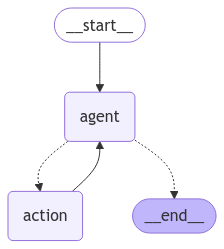

In [99]:
from langgraph.graph import StateGraph, END
from IPython.display import Image, display

uncompiled_graph = StateGraph(AgentState)

uncompiled_graph.add_node("agent", call_mode)
uncompiled_graph.add_node("action", tool_node)

uncompiled_graph.set_entry_point("agent")

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue
)

uncompiled_graph.add_edge("action", "agent")

# Compile and display the graph for a visual overview
compiled_graph = uncompiled_graph.compile()
display(Image(compiled_graph.get_graph(xray=True).draw_mermaid_png()))    

In [100]:
import time

for test_row in dataset:
    inputs = {"messages": [HumanMessage(content=test_row.eval_sample.user_input)]}
    response = compiled_graph.invoke(inputs)
    test_row.eval_sample.response = response["messages"][-1].content
    test_row.eval_sample.retrieved_contexts = extract_page_content(response["messages"][-2].content)
    time.sleep(60)


In [101]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,What role does the dome play in the creation n...,[together he called Seas. And God saw that it ...,[Chapter 1 [1:1] In the beginning when God cre...,"In the creation narrative, the dome plays a si...","In the creation narrative, the dome is created...",single_hop_specifc_query_synthesizer
1,In the context of the creation narrative found...,[is Pishon; it is the one that flows around th...,[Chapter 2 [2:1] Thus the heavens and the eart...,"In the creation narrative found in Genesis, th...","In the creation narrative of Genesis, the Euph...",single_hop_specifc_query_synthesizer
2,Why LORD God make man leave garden?,"[for out of it you were taken; you are dust, a...",[Chapter 3 [3:1] Now the serpent was more craf...,The LORD God made man leave the Garden of Eden...,The LORD God sent the man forth from the garde...,single_hop_specifc_query_synthesizer
3,Who was Eve in the context of Genesis Chapter 4?,[and a sword flaming and turning to guard the ...,[Chapter 4 [4:1] Now the man knew his wife Eve...,"In the context of Genesis Chapter 4, Eve is th...",Eve was the wife of Adam and the mother of Cai...,single_hop_specifc_query_synthesizer
4,What is the significance of Jared in the genea...,[Thus all the days of Kenan were nine hundred ...,[Chapter 5 [5:1] This is the list of the desce...,"In the genealogy of Adam, Jared is significant...",Jared is significant in the genealogy of Adam ...,single_hop_specifc_query_synthesizer
5,Why Jacob go to Bethel and what happen with hi...,"[Perizzites; my numbers are few, and if they g...",[<1-hop>\n\nChapter 35 [35:1] God said to Jaco...,Jacob went to Bethel because God instructed hi...,Jacob went to Bethel because God told him to a...,multi_hop_specific_query_synthesizer
6,How did Sarai's journey with Abram from Ur of ...,"[Sarai, Abram\, from the river of Egypt to the...","[<1-hop>\n\nher mother said, ""Let the girl rem...",Sarai's journey with Abram from Ur of the Chal...,"Sarai, Abram's wife, initially journeyed with ...",multi_hop_specific_query_synthesizer
7,"How did the Israelites, led by Jacob, end up i...","[Then he said, ""I am God, the God of your fath...",[<1-hop>\n\nChapter 37 [37:1] Jacob settled in...,"The Israelites, led by Jacob, ended up in Egyp...","The Israelites, led by Jacob, ended up in Egyp...",multi_hop_specific_query_synthesizer
8,How does the significance of Shechem in Abram'...,[and killed all the males. [34:26] They killed...,"[<1-hop>\n\nand his daughter-in-law Sarai, his...",The significance of Shechem in Abram's journey...,"In Abram's journey, Shechem is significant as ...",multi_hop_specific_query_synthesizer
9,What is the significance of Zebulun's settleme...,[],[<1-hop>\n\nfather laid his right hand on the ...,"Zebulun's settlement by the sea, as mentioned ...","In Jacob's blessings to his sons, Zebulun is p...",multi_hop_specific_query_synthesizer


In [102]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [103]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(init_chat_model("gpt-4o", temperature=0, rate_limiter=rate_limiter))

In [104]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=1440)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Exception raised in Job[59]: ValueError(zero-size array to reduction operation maximum which has no identity)


{'context_recall': 0.6167, 'faithfulness': 0.5558, 'factual_correctness': 0.6120, 'answer_relevancy': 0.9705, 'context_entity_recall': 0.5371, 'noise_sensitivity_relevant': 0.1488}

## Task 7: Assessing Performance


In [36]:
def calculate_metric_delta(run1:dict, run2:dict) -> dict:
    """
    calculate the delta between two metric runs.
    A positive delta means run2 is higher than run1.

    Args:
        run1(dict): First run metrics
        run2(dict): Second run metrics

    Returns:
        dict: Delta values for each metric
    """
    if not run1.keys() == run2.keys():
        raise ValueError("Both runs must contain the same metrics")

    delta = {}
    for metric in run1:
        delta[metric] = round((run2[metric] - run1[metric])/run1[metric], 4)
        print(f"{metric:<30} {run1[metric]:{10}.4f} {run2[metric]:{15}.4f} {delta[metric]:{10}.2%}")
        


In [38]:
print("Comparing the evaluation results")
print("                                 base-run      finetune-run   improved")
first_run = {'context_recall': 0.5500, 'faithfulness': 0.5588, 'factual_correctness': 0.6360, 'answer_relevancy': 0.8632, 'context_entity_recall': 0.5267, 'noise_sensitivity_relevant': 0.1293}
second_run = {'context_recall': 0.6167, 'faithfulness': 0.5558, 'factual_correctness': 0.6120, 'answer_relevancy': 0.9705, 'context_entity_recall': 0.5371, 'noise_sensitivity_relevant': 0.1488}

calculate_metric_delta(first_run, second_run)

Comparing the evaluation results
                                 base-run      finetune-run   improved
context_recall                     0.5500          0.6167     12.13%
faithfulness                       0.5588          0.5558     -0.54%
factual_correctness                0.6360          0.6120     -3.77%
answer_relevancy                   0.8632          0.9705     12.43%
context_entity_recall              0.5267          0.5371      1.97%
noise_sensitivity_relevant         0.1293          0.1488     15.08%


✅ Deliverables
1. By evaluating my agent graph with the base open source embedding model and the same agent graph with the fine tuned embedding model, the above 6 metrics show the performance of the fine tuned one is improved a lot especially on context recall, answer relevancy and noise sensitivity relevancy.
2. In the second half of the course, I plan to add more tools and resources in the agent graph. So it may be used by different groups of people in age, language, etc. 